In [25]:
import sys
import os
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
project_directory = os.path.dirname(parent_directory)
sys.path.append(project_directory + "/transition_path_sampling")
sys.path.append(project_directory + "/transition_path_generation")
import numpy as np
import csv
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from networks.tp_conditional_midpoint.conditional_net import NeuralNet as net1
import helpers
import math
import muller
import torch

In [26]:
grid_size = 100
x_start = -2.5
x_end = 1.5
y_start = -1
y_end = 2.5
def plot_contours(drift_func):
    x_grid, y_grid = np.meshgrid(np.linspace(x_start, x_end, grid_size), np.linspace(y_start, y_end, grid_size))
    z_grid = np.zeros((x_grid.shape[0], x_grid.shape[1]))
    tics = np.linspace(-150, 150, 30)
    for i in range(x_grid.shape[0]):
        for j in range(x_grid.shape[1]):
            z_grid[i] = drift_func.get_potential(np.vstack([x_grid[i], y_grid[i]]).T)
    CS = plt.contour(x_grid, y_grid, z_grid, tics)
    plt.clabel(CS, inline=False, fontsize=10)

In [27]:
def visualize(data, drift_func=muller):
    plot_contours(drift_func)
    for i in range(data.shape[0]):
        plt.plot(data[i,:,0], data[i,:,1])
        plt.xlim([-2.5, 1.5])
        plt.ylim([-1, 2.5])
        plt.xlabel("X")
        plt.ylabel("Y")
    plt.show()

In [28]:
def forward_gen(x, t_vals, beta, mu):
    for i in range(t_vals.shape[0]):
        if i == 0:
            x_diff = np.random.normal(size=x.shape) * np.sqrt(t_vals[i])
            x = x - beta * (x - np.tile(mu, (x.shape[0], x.shape[1], 1))) * (t_vals[i]) + x_diff
        else:
            x_diff = np.random.normal(size=x.shape) * np.sqrt(t_vals[i] - t_vals[i-1])
            x = x - beta * (x - np.tile(mu, (x.shape[0], x.shape[1], 1))) * (t_vals[i] - t_vals[i-1]) + x_diff
    return x

In [29]:
def backward_gen(x, func, t_vals, beta, mu, levels, times, plot=True, bridge=False):
    l = t_vals.shape[0]
    tp_len = 2 ** levels + 1
    if times.shape[0] == x.shape[0]:
        path_t = torch.tensor(times).float()
    else:
        print("invalid times")
        path_t = torch.ones(x.shape[0]) * 0.02
    for i in tqdm(range(t_vals.shape[0])):
        if i == l - 1:
            step = t_vals[l - i - 1]
        else:
            step = t_vals[l - i - 1] - t_vals[l - i - 2]
        x_stoc = np.random.normal(size=x[:,0].shape) * np.sqrt((np.exp((2 * beta) * step) - 1)/(2 * beta))
        score = func.initial_score(torch.tensor(x[:, 0]).float(), t_vals[l - i - 1], path_t).detach().numpy()
        x_drift = (1 / beta) * (np.exp(beta * step) - 1) * score + np.exp(beta * step) * x[:,0]
        x[:,0] = x_stoc + x_drift
    for i in tqdm(range(t_vals.shape[0])):
        if i == l - 1:
            step = t_vals[l - i - 1]
        else:
            step = t_vals[l - i - 1] - t_vals[l - i - 2]
        x_stoc = np.random.normal(size=x[:,-1].shape) * np.sqrt((np.exp((2 * beta) * step) - 1)/(2 * beta))
        score = func.final_score(torch.tensor(x[:, -1]).float(),torch.tensor(x[:, 0]).float(), t_vals[l - i - 1], path_t).detach().numpy()
        x_drift = (1 / beta) * (np.exp(beta * step) - 1) * score + np.exp(beta * step) * x[:,-1]
        x[:,-1] = x_stoc + x_drift
    for j in range(levels):
        x_temp = np.zeros((x.shape[0], 2 ** j, 2))
        diff = 2 ** (levels - j - 1)
        start = diff
        for i in range(2 ** j):
            x_temp[:, i] = x[:, (2 * i + 1) * diff]
        for i in tqdm(range(t_vals.shape[0])):
            if i == l - 1:
                step = t_vals[l - i - 1]
            else:
                step = t_vals[l - i - 1] - t_vals[l - i - 2]
            x_stoc = np.random.normal(size=x_temp.shape) * np.sqrt((np.exp((2 * beta) * step) - 1)/(2 * beta))
            score = np.zeros_like(x_temp)
            for k in range(2 ** j):
                score[:, k] += func.score(torch.tensor(x_temp[:, k]).float(), torch.tensor(x[:, (2 * k) * diff]).float(), torch.tensor(x[:, (2 * k + 2) * diff]).float(), t_vals[l - i - 1], path_t * (2 * diff / (tp_len - 1))).detach().numpy()
            x_drift = (1 / beta) * (np.exp(beta * step) - 1) * score + np.exp(beta * step) * x_temp
            x_temp = x_stoc + x_drift
        for i in range(2 ** j):
            x[:, (2 * i + 1) * diff] = x_temp[:, i]
        if plot:
            visualize(x[:10,::diff])
    return x

In [30]:
nn_path = project_directory + "/data/nets/bridge_test"
output_path = project_directory + '/data/transition_paths/diff_test'

save = True

net = net1

tp_len = 9
mu = torch.tensor([0,0])

sig_min = 0.005
const = 2.2
n = 105
beta = 0.5

vals = helpers.get_times(sig_min, const, n, beta).detach().numpy()
t_vals = vals[:,0]
h_vals = vals[:,1]
sigmas = vals[:,2]
print(max(t_vals))
print(t_vals)

7.7644806
[5.0273631e-03 5.0826892e-03 5.1392373e-03 5.1970473e-03 5.2561620e-03
 5.3166253e-03 5.3784838e-03 5.4417867e-03 5.5065840e-03 5.5729295e-03
 5.6408793e-03 5.7104910e-03 5.7818266e-03 5.8549508e-03 5.9299306e-03
 6.0068374e-03 6.0857460e-03 6.1667352e-03 6.2498879e-03 6.3352911e-03
 6.4230366e-03 6.5132221e-03 6.6059493e-03 6.7013274e-03 6.7994702e-03
 6.9004986e-03 7.0045413e-03 7.1117347e-03 7.2222217e-03 7.3361564e-03
 7.4537005e-03 7.5750281e-03 7.7003227e-03 7.8297798e-03 7.9636108e-03
 8.1020370e-03 8.2452968e-03 8.3936481e-03 8.5473629e-03 8.7067354e-03
 8.8720806e-03 9.0437382e-03 9.2220716e-03 9.4074756e-03 9.6003748e-03
 9.8012276e-03 1.0010531e-02 1.0228825e-02 1.0456694e-02 1.0694777e-02
 1.0943766e-02 1.1204420e-02 1.1477569e-02 1.1764123e-02 1.2065079e-02
 1.2381539e-02 1.2714714e-02 1.3065947e-02 1.3436728e-02 1.3828710e-02
 1.4243737e-02 1.4683872e-02 1.5151430e-02 1.5649013e-02 1.6179558e-02
 1.6746396e-02 1.7353315e-02 1.8004643e-02 1.8705342e-02 1.9461131e

In [31]:
learning_rate = 0.01
model = net(beta, mu)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

checkpoint = torch.load(nn_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
min_sigma = checkpoint['min_sigma']

model.eval()

NeuralNet(
  (score): ScoreModule(
    (fc1): Linear(in_features=8, out_features=60, bias=True)
    (tanh1): Tanh()
    (fc2): Linear(in_features=60, out_features=200, bias=True)
    (tanh2): LeakyReLU(negative_slope=0.01)
    (fc3): Linear(in_features=200, out_features=400, bias=True)
    (tanh3): LeakyReLU(negative_slope=0.01)
    (fc4): Linear(in_features=400, out_features=1000, bias=True)
    (tanh4): LeakyReLU(negative_slope=0.01)
    (fc5): Linear(in_features=1000, out_features=1000, bias=True)
    (tanh5): LeakyReLU(negative_slope=0.01)
    (fc6): Linear(in_features=1000, out_features=300, bias=True)
    (tanh6): LeakyReLU(negative_slope=0.01)
    (fc7): Linear(in_features=300, out_features=120, bias=True)
    (tanh7): LeakyReLU(negative_slope=0.01)
    (fc8): Linear(in_features=120, out_features=30, bias=True)
    (fin_relu): LeakyReLU(negative_slope=0.01)
    (fin): Linear(in_features=30, out_features=2, bias=True)
  )
  (initial_score): InitialPointModule(
    (fc1): Linear(i

In [32]:
data_path = project_directory + '/data/transition_paths/muller_tps.txt'
file = open(data_path)
csvreader = csv.reader(file)

c = 0
tps = []
for row in csvreader:
    if c > 300:
        break
    arr = np.zeros((len(row), 2))
    for i in range(arr.shape[0]):
        str_list = row[i].strip('[]').split()
        arr[i] = np.array([float(num) for num in str_list])
    arr.astype(float)
    tps.append(arr)
    c+=1
file.close()

arr = np.array(tps).astype(float)
arr = helpers.reshape_ts_np(arr, tp_len)
times = arr[:,-1,0]
arr = arr[:,:-1]
print(arr.shape)

print(np.mean(times))

(301, 9, 2)
0.020069102990033224


In [33]:
import scipy.stats
from scipy.optimize import curve_fit

params = scipy.stats.lognorm.fit(times)
dist = scipy.stats.lognorm
X = np.linspace(0,0.07, 10)
pdf_fitted = dist.pdf(X, *params)

times = dist.rvs(params[0], params[1], params[2], size=4000)
print(times)
print(np.mean(times))

[0.02626841 0.00898024 0.00804782 ... 0.0071982  0.0498752  0.0118675 ]
0.020134701078925885


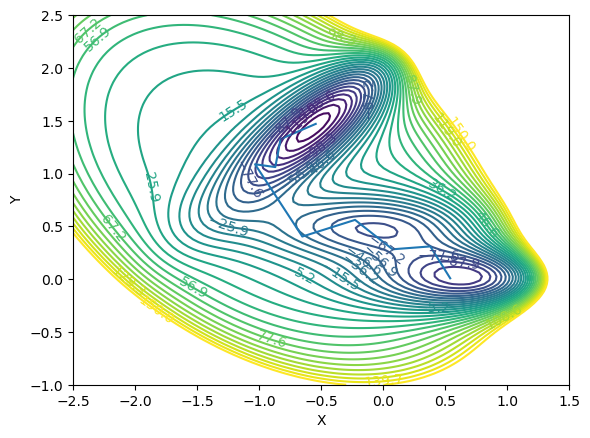

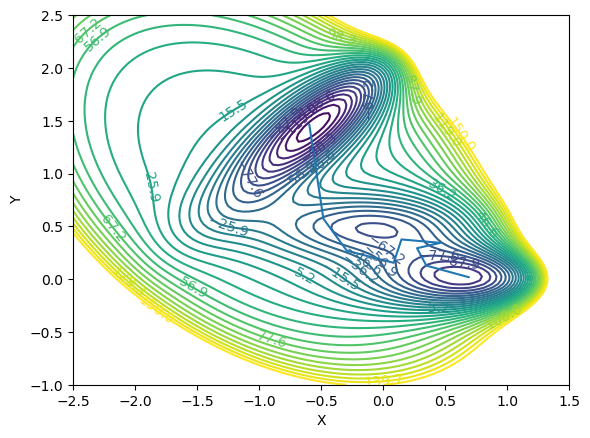

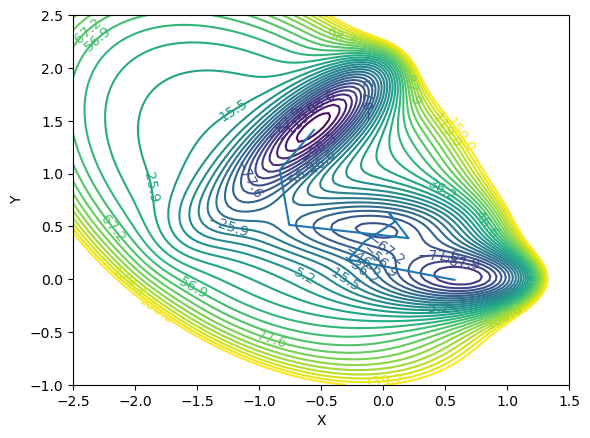

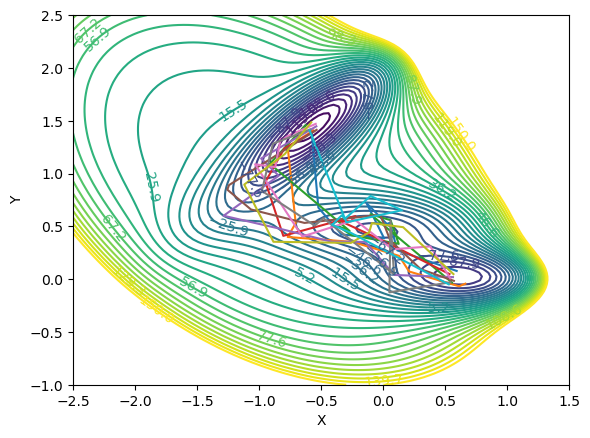

100%|██████████| 105/105 [04:40<00:00,  2.67s/it]


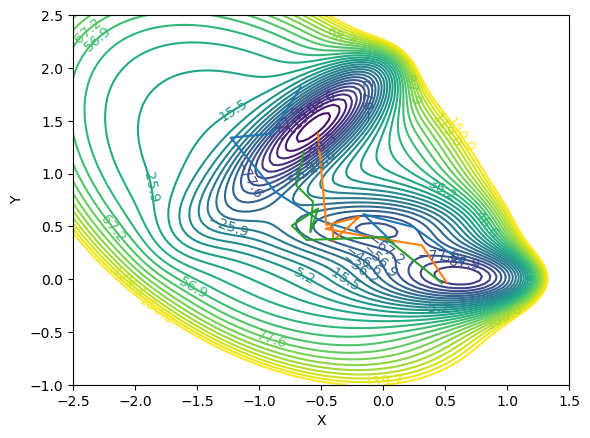

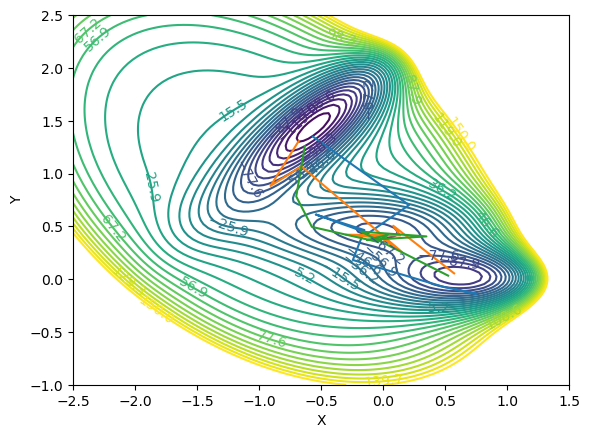

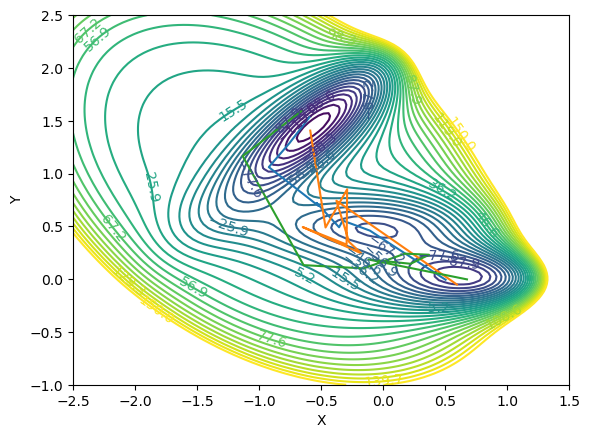

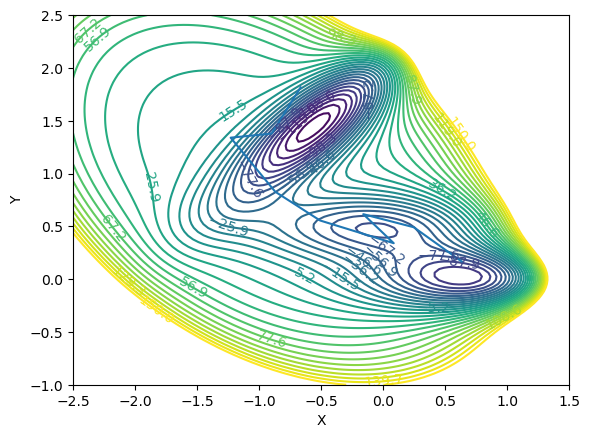

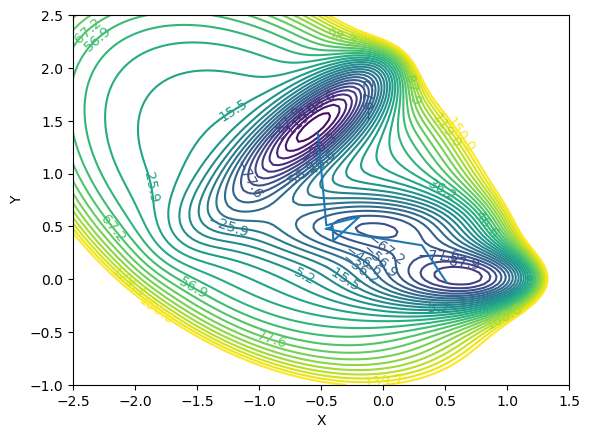

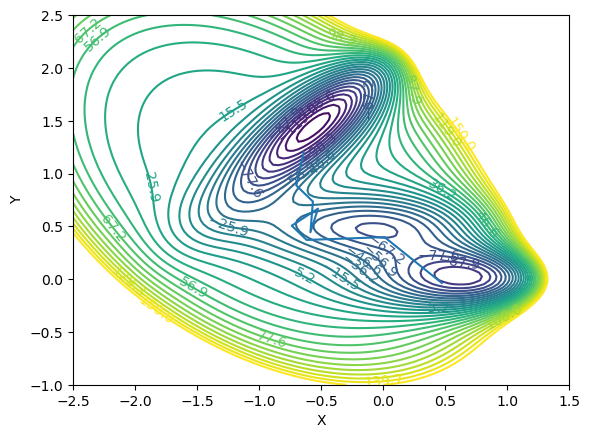

In [34]:
r = np.random.randint(0, 100, size=3)
visualize(data=arr[r[0]:r[0]+1])
visualize(data=arr[r[1]:r[1]+1])
visualize(data=arr[r[2]:r[2]+1])
visualize(data=arr[0:10])

data = forward_gen(arr, t_vals, beta, mu)
# visualize(data=data[0:5])


data = np.random.normal(size=(4000, tp_len, 2)) * (np.sqrt((1 - np.exp(-2 * beta * max(t_vals))) / (2 * beta)).item())
#NO MU
data = backward_gen(data, model, t_vals, beta, mu, int(np.round(np.log2(tp_len-1))), times, plot=False)

visualize(data=data[0:3])
visualize(data=data[3:6])
visualize(data=data[6:9])
visualize(data=data[0:1])
visualize(data=data[1:2])
visualize(data=data[2:3])

In [35]:
if save:
    with open(output_path, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)